## Models for Original Audios

In [1]:
#Importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from itertools import product
from scipy.stats import f_oneway, ttest_rel
from sklearn.feature_selection import chi2
from sklearn.preprocessing import KBinsDiscretizer
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(r"C:\Users\pavan\Documents\Fall 2024\EE502 ML in Bio\Final Project\SWC\language_features.csv")

In [3]:
df

,MFCC_0,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,...,Chroma_10,Chroma_11,SpectralContrast_0,SpectralContrast_1,SpectralContrast_2,SpectralContrast_3,SpectralContrast_4,SpectralContrast_5,SpectralContrast_6,Label
0,-481.751282,101.014961,-7.370456,21.011026,11.820652,-5.823113,-7.208418,-1.639658,-9.234241,-2.033903,...,0.511279,0.481678,17.389723,9.665587,12.711685,13.156577,17.081439,22.944283,42.031040,Dutch
1,-355.555359,100.489540,26.064215,42.599300,21.112593,15.803838,4.642409,9.552911,-2.831193,8.441623,...,0.785947,0.720931,9.259313,6.945292,9.818391,11.259890,13.109528,16.916209,37.991576,Dutch
2,-494.728485,97.049171,-5.943329,22.197573,13.259092,-6.565980,-3.329051,0.884476,-13.324694,-1.061518,...,0.556531,0.563684,17.660488,9.806260,12.305297,12.708329,16.309950,21.774346,41.380397,Dutch
3,-353.211548,102.637695,27.485174,47.475529,24.500154,14.251774,1.510977,4.879726,-1.098654,9.034349,...,0.779655,0.723628,9.191273,6.845349,10.263353,11.030561,13.637188,16.902319,37.185443,Dutch
4,-473.017883,107.046059,-8.093265,26.144173,13.502638,-7.952041,-8.666633,-4.238086,-12.634802,-1.816826,...,0.492018,0.502157,17.827660,9.413820,13.027685,13.163255,16.825848,24.021220,44.314994,Dutch
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2644,-441.428864,95.669502,32.085533,34.698902,20.461151,-0.475378,8.035894,-3.620089,-3.110109,-3.639597,...,0.695217,0.698840,11.728764,10.329983,12.334888,12.719680,15.502206,20.461433,35.440421,German
2645,-454.606873,85.218689,27.676006,24.765591,14.181431,12.457692,-17.883406,-1.003497,-6.397526,-2.016774,...,0.596567,0.571909,11.238386,6.488327,11.187408,12.119758,16.856789,19.110739,41.296085,German
2646,-464.066772,82.006477,28.987843,23.478230,15.306504,10.379747,-15.582608,-0.790893,-7.390070,-2.890126,...,0.626962,0.596748,11.151246,6.709475,11.221020,11.806763,15.774451,18.755532,39.549192,German
2647,-470.648743,79.966324,28.612371,24.228798,14.908826,10.501396,-15.625713,-1.218402,-6.861120,-4.063834,...,0.601797,0.585980,11.345039,6.629659,11.267346,11.720325,15.722433,18.729630,39.627918,German


### Visualizing the Classification of Audios

Total audio samples: 2649
Label
Dutch      917
German     894
English    838
Name: count, dtype: int64


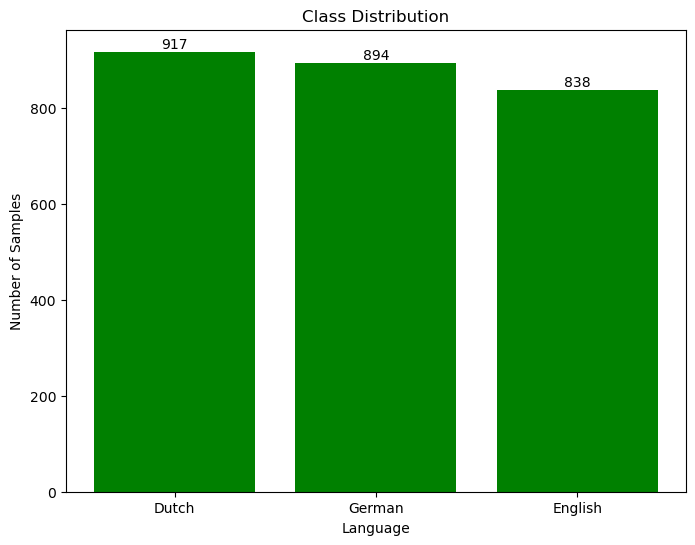

In [4]:
#Checking the count of classes
class_counts = df['Label'].value_counts()
total_samples = class_counts.sum()
print(f'Total audio samples: {total_samples:}')
print(class_counts)

# Plotting the class distribution
plt.figure(figsize=(8, 6))
bars = plt.bar(class_counts.index, class_counts.values, color='Green')
plt.title('Class Distribution')
plt.xlabel('Language')
plt.ylabel('Number of Samples')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom')

plt.show()


### Preprocessing and Normalization

In [5]:
X = df.drop(columns=["Label"])
y = df["Label"]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

#Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) 


### Splitting the dataset
#### Test size 30% and Train size 70%

In [6]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

### PCA

In [ ]:

# Apply PCA
pca = PCA(n_components=5)  #keeping n as 5 components
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)



### Random Forest Model with PCA

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Fitting 3 folds for each of 108 candidates, totalling 324 fits

Cross-Validation Results (F1 Score, Accuracy):
[[0.7394884  0.73584906]
 [0.72569195 0.72237197]
 [0.76968615 0.76819407]
 [0.7485858  0.74393531]
 [0.72219197 0.71621622]]
Mean F1 Score of RF with PCA: 0.74
Mean Accuracy of RF with PCA: 0.74

Best Parameters from Grid Search of RF with PCA: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Test Set F1 Score of RF with PCA: 0.75
Test Set Accuracy of RF with PCA: 0.75

Classification Report of RF with PCA:
              precision    recall  f1-score   support

           0       0.93      0.83      0.88       275
           1       0.64      0.69      0.67       258
           2       0.68  

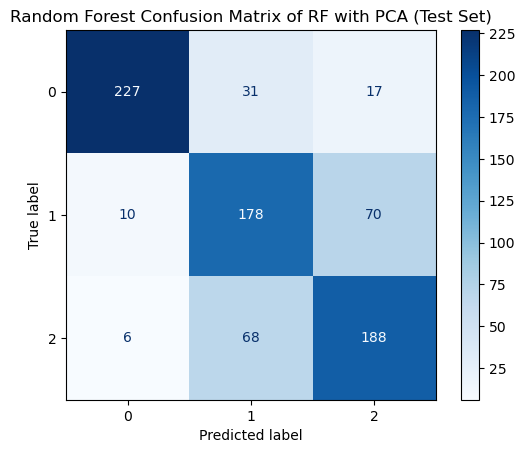

In [8]:
#cross validation
# Stratified K-Fold
n_splits = 5  # Number of folds
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Grid Search
param_grid_rf_pca = {
    'n_estimators': [50, 100, 200],                
    'max_depth': [None, 10, 20, 30],               
    'min_samples_split': [2, 5, 10],               
    'min_samples_leaf': [1, 2, 4],                 
}

# Storing the Cross-validation results
cv_results = []
best_params = None

for train_index, val_index in skf.split(X_train_pca, y_train):
    X_cv_train, X_cv_val = X_train_pca[train_index], X_train_pca[val_index]
    y_cv_train, y_cv_val = y_train[train_index], y_train[val_index]
    
    # Grid Search for each fold
    rf_pca = RandomForestClassifier(random_state=42)
    grid_search_rf = GridSearchCV(rf_pca, param_grid_rf_pca, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
    grid_search_rf.fit(X_cv_train, y_cv_train)
    
    #best model from Grid Search
    best_rf = grid_search_rf.best_estimator_
    rf_pred = best_rf.predict(X_cv_val)
    
    # Computing F1 Score and Accuracy for each  fold
    rf_f1 = f1_score(y_cv_val, rf_pred, average='weighted')
    accuracy_rf = accuracy_score(y_cv_val, rf_pred)
    cv_results.append((rf_f1, accuracy_rf))
    
    # best parameters
    best_params = grid_search_rf.best_params_

# Training the model
final_rf_pca = RandomForestClassifier(**best_params, random_state=42)
final_rf_pca.fit(X_train_pca, y_train)

# Evaluation
rf_pred_test = final_rf_pca.predict(X_test_pca)
rf_f1_test = f1_score(y_test, rf_pred_test, average='weighted')
accuracy_rf_test = accuracy_score(y_test, rf_pred_test)

# Print results
print("\nCross-Validation Results (F1 Score, Accuracy):")
print(np.array(cv_results))
print(f"Mean F1 Score of RF with PCA: {np.mean([r[0] for r in cv_results]):.2f}")
print(f"Mean Accuracy of RF with PCA: {np.mean([r[1] for r in cv_results]):.2f}")
print("\nBest Parameters from Grid Search of RF with PCA:", best_params)
print(f"Test Set F1 Score of RF with PCA: {rf_f1_test:.2f}")
print(f"Test Set Accuracy of RF with PCA: {accuracy_rf_test:.2f}")
print("\nClassification Report of RF with PCA:")
print(classification_report(y_test, rf_pred_test))

# Confusion Matrix
rf_conf_matrix = confusion_matrix(y_test, rf_pred_test)
ConfusionMatrixDisplay(rf_conf_matrix).plot(cmap='Blues')
plt.title("Random Forest Confusion Matrix of RF with PCA (Test Set)")
plt.show()


### SVM Model

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fold 1: F1 Score = 0.85, Accuracy = 0.85
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fold 2: F1 Score = 0.84, Accuracy = 0.84
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fold 3: F1 Score = 0.84, Accuracy = 0.84
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fold 4: F1 Score = 0.83, Accuracy = 0.83
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fold 5: F1 Score = 0.82, Accuracy = 0.82

Cross-Validation Summary:
Mean F1 Score: 0.84
Mean Accuracy: 0.84
Best Parameters Across Folds: [{'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}, {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}, {'C': 10, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}, {'C': 100, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}, {'C': 10, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}]

Final Model Performance on Test Set:
Test F1 Score: 0.86
Test Accuracy: 0.86

Classification

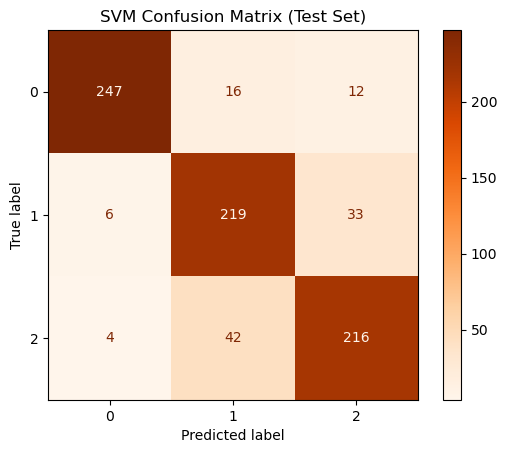

In [9]:

# Grid Search
param_grid_svm = {
    'C': [0.1, 1, 10, 100],                   
    'kernel': ['linear', 'rbf', 'poly'],      
    'gamma': ['scale', 'auto'],             
    'degree': [2, 3, 4]                     
}

#Stratified K-Fold
n_splits = 5  # Number of folds
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Cross-validation results storage
cv_f1_scores = []
cv_accuracy_scores = []
best_params_list = []

# Cross-validation 
for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train), start=1):
    X_cv_train, X_cv_val = X_train[train_index], X_train[val_index]
    y_cv_train, y_cv_val = y_train[train_index], y_train[val_index]
    
    # Grid Search with SVM for each fold
    svm = SVC(random_state=42)
    grid_search_svm = GridSearchCV(svm, param_grid_svm, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
    grid_search_svm.fit(X_cv_train, y_cv_train)
    
    # Get the best model
    best_svm = grid_search_svm.best_estimator_
    svm_pred = best_svm.predict(X_cv_val)
    
    # Evaluation
    fold_f1 = f1_score(y_cv_val, svm_pred, average='weighted')
    fold_accuracy = accuracy_score(y_cv_val, svm_pred)
    cv_f1_scores.append(fold_f1)
    cv_accuracy_scores.append(fold_accuracy)
    
    # Save the best parameters
    best_params_list.append(grid_search_svm.best_params_)
    
    print(f"Fold {fold}: F1 Score = {fold_f1:.2f}, Accuracy = {fold_accuracy:.2f}")

# cross-validation results
mean_f1 = np.mean(cv_f1_scores)
mean_accuracy = np.mean(cv_accuracy_scores)

print("\nCross-Validation Summary:")
print(f"Mean F1 Score: {mean_f1:.2f}")
print(f"Mean Accuracy: {mean_accuracy:.2f}")
print(f"Best Parameters Across Folds: {best_params_list}")

# Training the model
final_svm = SVC(**grid_search_svm.best_params_, random_state=42)
final_svm.fit(X_train, y_train)

# Evaluation
svm_pred_test = final_svm.predict(X_test)
svm_f1_test = f1_score(y_test, svm_pred_test, average='weighted')
svm_accuracy_test = accuracy_score(y_test, svm_pred_test)

print(f"\nFinal Model Performance on Test Set:")
print(f"Test F1 Score: {svm_f1_test:.2f}")
print(f"Test Accuracy: {svm_accuracy_test:.2f}")
print("\nClassification Report for Test Set:")
print(classification_report(y_test, svm_pred_test))

# Confusion Matrix
svm_conf_matrix = confusion_matrix(y_test, svm_pred_test)
ConfusionMatrixDisplay(svm_conf_matrix).plot(cmap='Oranges')
plt.title("SVM Confusion Matrix (Test Set)")
plt.show()


### HMM Model

Starting Grid Search...
Training with params: n_components=3, covariance_type=diag, n_iter=50
Training with params: n_components=3, covariance_type=diag, n_iter=100
Training with params: n_components=3, covariance_type=full, n_iter=50
Training with params: n_components=3, covariance_type=full, n_iter=100

Best Parameters Found:
{'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}
Best F1-Score: 0.2460

HMM Model Performance with Best Parameters:
F1-Score: 0.2460
Accuracy: 0.30

Classification Report:
              precision    recall  f1-score   support

           0       0.18      0.03      0.06       275
           1       0.38      0.24      0.29       258
           2       0.29      0.65      0.40       262

    accuracy                           0.30       795
   macro avg       0.28      0.31      0.25       795
weighted avg       0.28      0.30      0.25       795



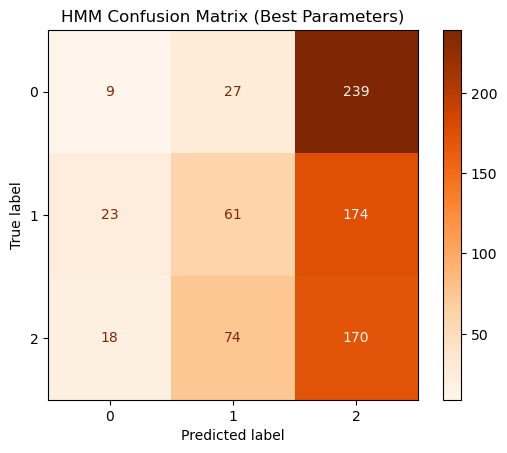

In [10]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


X_train_seq = np.concatenate(X_train_scaled).reshape(-1, 1)
X_test_seq = np.concatenate(X_test_scaled).reshape(-1, 1)

train_lengths = [X_train.shape[1]] * X_train.shape[0]  
test_lengths = [X_test.shape[1]] * X_test.shape[0]  

param_grid = {
    'n_components': [3],  
    'covariance_type': ['diag', 'full'], 
    'n_iter': [50, 100]  
}

best_score = -np.inf
best_params = None
best_model = None


print("Starting Grid Search...")
for n_components, covariance_type, n_iter in product(param_grid['n_components'], param_grid['covariance_type'], param_grid['n_iter']):
    print(f"Training with params: n_components={n_components}, covariance_type={covariance_type}, n_iter={n_iter}")
    hmm_model = hmm.GaussianHMM(n_components=n_components, covariance_type=covariance_type, n_iter=n_iter, random_state=42)
    try:
        hmm_model.fit(X_train_seq, lengths=train_lengths)
        
        hmm_predictions = hmm_model.predict(X_test_seq, lengths=test_lengths)
        
        
        split_indices = np.cumsum(test_lengths[:-1])  
        grouped_predictions = np.split(hmm_predictions, split_indices)
        aggregated_predictions = [np.bincount(group).argmax() for group in grouped_predictions]
        
        
        hmm_f1 = f1_score(y_test_encoded, aggregated_predictions, average='weighted')
        
        if hmm_f1 > best_score:
            best_score = hmm_f1
            best_params = {
                'n_components': n_components,
                'covariance_type': covariance_type,
                'n_iter': n_iter
            }
            best_model = hmm_model
    except Exception as e:
        print(f"Error with params {n_components, covariance_type, n_iter}: {e}")
        continue

print("\nBest Parameters Found:")
print(best_params)
print(f"Best F1-Score: {best_score:.4f}")


if best_model is not None:
    hmm_predictions = best_model.predict(X_test_seq, lengths=test_lengths)
    
    
    split_indices = np.cumsum(test_lengths[:-1])
    grouped_predictions = np.split(hmm_predictions, split_indices)
    aggregated_predictions = [np.bincount(group).argmax() for group in grouped_predictions]
    
    
    assert len(aggregated_predictions) == len(y_test_encoded)
    
    
    accuracy_hmm = accuracy_score(y_test_encoded, aggregated_predictions)
    
    print("\nHMM Model Performance with Best Parameters:")
    print(f"F1-Score: {best_score:.4f}")
    print(f"Accuracy: {accuracy_hmm:.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test_encoded, aggregated_predictions, target_names=list(map(str, label_encoder.classes_))))
    
    # Confusion Matrix
    hmm_conf_matrix = confusion_matrix(y_test_encoded, aggregated_predictions)
    ConfusionMatrixDisplay(hmm_conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Oranges')
    plt.title("HMM Confusion Matrix (Best Parameters)")
    plt.show()
else:
    print("No valid model found during grid search.")


### Statstical Tests

#### ANOVA Test on models

In [11]:

X = X_scaled  
y = y_encoded  

#Stratified K-Fold
n_splits = 5  # Number of folds
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

rf_f1_scores = []
svm_f1_scores = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Random Forest
    rf = RandomForestClassifier(n_estimators=200, random_state=42)
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_test)
    rf_f1_scores.append(f1_score(y_test, rf_pred, average='weighted'))
    
    # SVM
    svm = SVC(C=10, kernel='rbf', random_state=42)
    svm.fit(X_train, y_train)
    svm_pred = svm.predict(X_test)
    svm_f1_scores.append(f1_score(y_test, svm_pred, average='weighted'))
    

f1_scores_df = pd.DataFrame({
    'Random Forest': rf_f1_scores,
    'SVM': svm_f1_scores,
})

# Display F1-scores
print("\nF1-Scores for Each Model Across Folds:")
print(f1_scores_df)

# Perform statistical comparisons
# ANOVA test to compare the mean F1-scores
anova_result = f_oneway(f1_scores_df['Random Forest'], f1_scores_df['SVM'])
print(f"\nANOVA Test:\nF-statistic = {anova_result.statistic:.4f}, p-value = {anova_result.pvalue:.4f}")




F1-Scores for Each Model Across Folds:
   Random Forest       SVM
0       0.836219  0.828817
1       0.848088  0.855575
2       0.842453  0.858588
3       0.826580  0.885444
4       0.827541  0.840469

ANOVA Test:
F-statistic = 2.8463, p-value = 0.1301


#### CHI-Square Test on Features

In [12]:

X = df.drop(columns=['Label'])
y = df['Label']

kbins = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
X_binned = kbins.fit_transform(X)

# Perform Chi-Square test
chi2_scores, p_values = chi2(X_binned, y)

chi2_results = pd.DataFrame({
    'Feature': X.columns,
    'Chi2 Score': chi2_scores,
    'p-value': p_values
})

# Display the Chi-Square test results
print(chi2_results)



               Feature  Chi2 Score        p-value
0               MFCC_0   25.609897   2.747145e-06
1               MFCC_1   19.079235   7.194435e-05
2               MFCC_2   89.317419   4.026881e-20
3               MFCC_3   53.471515   2.447981e-12
4               MFCC_4   11.937827   2.557019e-03
5               MFCC_5   89.055969   4.589253e-20
6               MFCC_6   44.852769   1.821146e-10
7               MFCC_7    9.330423   9.417258e-03
8               MFCC_8   38.314970   4.786411e-09
9               MFCC_9   19.178584   6.845787e-05
10             MFCC_10   56.850285   4.519781e-13
11             MFCC_11  225.816048   9.218669e-50
12             MFCC_12   54.024594   1.856557e-12
13            Chroma_0   25.698354   2.628290e-06
14            Chroma_1    8.028275   1.805852e-02
15            Chroma_2   10.323651   5.731227e-03
16            Chroma_3   15.870585   3.578873e-04
17            Chroma_4   26.715622   1.580434e-06
18            Chroma_5   35.042642   2.458028e-08


#### Top 7 results for chi-square test

In [13]:
top_7_features = chi2_results.sort_values(by='Chi2 Score', ascending=False).head(7)

# Display the top 7 results
print("Top 7 Features Based on Chi-Square Test:")
print(top_7_features)

Top 7 Features Based on Chi-Square Test:
               Feature  Chi2 Score        p-value
25  SpectralContrast_0  504.026444  3.564907e-110
26  SpectralContrast_1  311.101923   2.786607e-68
11             MFCC_11  225.816048   9.218669e-50
2               MFCC_2   89.317419   4.026881e-20
5               MFCC_5   89.055969   4.589253e-20
24           Chroma_11   84.318620   4.902801e-19
23           Chroma_10   78.126458   1.084064e-17
